In [11]:
# Imports libraries 
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import os
import mediapy as media
from tqdm import tqdm
import mujoco_viewer

# Robotics toolbox and dependencies
import roboticstoolbox as rtb
import spatialmath as sm
from spatialmath import UnitQuaternion, SE3
from spatialmath.base import q2r, r2x, rotx, roty, rotz, r2q, q2r
from mujoco_parser import MuJoCoParserClass

# Import local libraries
from Ur5e import Ur5e
from actuator import ActuatorMotor, update_actuator
from quaternion_helper import *

In [12]:
# Make ur5e instance
if 'ur5e' in locals():
    print('ur5e already exists')
    del ur5e

try:
    ur5e
except NameError:
    print('ur5e does not exist')
    ur5e = Ur5e()

ur5e already exists
ur5e does not exist


In [13]:
# Make actuator instance torque controlled
try:
    actuator
except NameError:
    actuator = ActuatorMotor()

forces_ctrl_range = np.array([[-150, 150], [-150, 150], [-150, 150], [-28, 28], [-28, 28], [-28, 28]])

for actuator_id in range(ur5e.m.nu):
    update_actuator(ur5e.m, actuator_id, actuator, ctrlrange=forces_ctrl_range[actuator_id])

In [14]:
# Visualize mujoco, Show initial state of the scene

# Use forward dynamics to get the initial state of the data
mujoco.mj_forward(ur5e.m, ur5e.d)
# render the initial state
if 'renderer' in locals():
    print('renderer already exists')
    del renderer


try:
    renderer
except NameError:
    renderer = mujoco.Renderer(ur5e.m, 480, 640)


#renderer.update_scene(ur5e.d, camera="fixed", scene_option=dict())
# show image
#media.show_image(renderer.render())

renderer already exists


# Trajectory

In [15]:
poi = np.array([
    #[93, 243],
    [500, 550],
    [130, 243],
    [130, 223],
    [175, 223],
    [175, 263],
    [130, 263],
    [130, 223],
    [175, 223],
    [175, 243],
    [213, 243],
    [213, 223],
    [254, 223],
    [254, 164],
    [334, 164],
    [334, 144],
    [379, 144],
    [379, 184],
    [334, 184],
    [334, 144],
    
])

poi = poi + np.array([0, -281])

#print(poi)
#plt.plot(poi[:, 0], poi[:, 1])
#plt.show()

'''
    [379, 144],
    [379, 164],
    [663, 164],
    [663, 271],
    [648, 271],
    [648, 289],
    [663, 289],
    [663, 392],
    [379, 392],
    [379, 372],
    [334, 372],
    [334, 412],
    [379, 412],
    [379, 372],
    [334, 372],
    [334, 392],
    [254, 392],
    [254, 339],
    [213, 339],
    [213, 319],
    [175, 319],
    [175, 339],
    [130, 339],
    [130, 319],
    [93, 319],
    [130, 319],
    [130, 299],
    [175, 299],
    [175, 319],
    [213, 319],
    [213, 299],
    [297, 299],
    [297, 339],
    [213, 339],
    [213, 299],
    [297, 299],
    [297, 319],
    [334, 319],
    [334, 299],
    [379, 299],
    [379, 339],
    [334, 339],
    [334, 299],
    [379, 299],
    [379, 319],
    [435, 319],
    [435, 292],
    [444, 281],
    [480, 281],
    [480, 261],
    [525, 261],
    [525, 281],
    [565, 281],
    [565, 301],
    [648, 301],
    [648, 261],
    [565, 261],
    [565, 281],
    [525, 281],
    [525, 301],
    [480, 301],
    [480, 281],
    [444, 281],
    [435, 272],
    [425, 281],
    [435, 292],
    [444, 281],
    [435, 272],
    [435, 243],
    [379, 243],
    [379, 263],
    [334, 263],
    [334, 243],
    [297, 243],
    [297, 263],
    [213, 263],
    [213, 223],
    [297, 223],
    [297, 243],
    [334, 243],
    [334, 223],
    [379, 223],
    [379, 243]
    '''

'\n    [379, 144],\n    [379, 164],\n    [663, 164],\n    [663, 271],\n    [648, 271],\n    [648, 289],\n    [663, 289],\n    [663, 392],\n    [379, 392],\n    [379, 372],\n    [334, 372],\n    [334, 412],\n    [379, 412],\n    [379, 372],\n    [334, 372],\n    [334, 392],\n    [254, 392],\n    [254, 339],\n    [213, 339],\n    [213, 319],\n    [175, 319],\n    [175, 339],\n    [130, 339],\n    [130, 319],\n    [93, 319],\n    [130, 319],\n    [130, 299],\n    [175, 299],\n    [175, 319],\n    [213, 319],\n    [213, 299],\n    [297, 299],\n    [297, 339],\n    [213, 339],\n    [213, 299],\n    [297, 299],\n    [297, 319],\n    [334, 319],\n    [334, 299],\n    [379, 299],\n    [379, 339],\n    [334, 339],\n    [334, 299],\n    [379, 299],\n    [379, 319],\n    [435, 319],\n    [435, 292],\n    [444, 281],\n    [480, 281],\n    [480, 261],\n    [525, 261],\n    [525, 281],\n    [565, 281],\n    [565, 301],\n    [648, 301],\n    [648, 261],\n    [565, 261],\n    [565, 281],\n    [525, 28

In [16]:
# Generate trajectory

#startpos = np.array([0, 0, 0])
T0 = sm.SE3.Trans(0.0, 0, 0.301) * sm.SE3.RPY([0, np.pi, 0]) # sm.SE3.Trans(0.5, 0, 0.3) * sm.SE3.RPY([0, np.pi, 0]) changed z from 0.3 to 0.4 to avoid collision
T1 = sm.SE3.Trans(0.0, 0, 0.301) * sm.SE3.RPY([0, np.pi, 0])
dt = 0.002 
endTime = 0.3
n = int(endTime/dt)

if 'ctr' not in locals():
    ctr = np.array([])
    times = np.array([])
    startTime = 0
    scalingX = 5000
    scalingY = 2500
    movementX = 0.4
    movementY = 0.0



    for i in tqdm(range(0, poi.shape[0]-1)):
        distance = np.sqrt((poi[i+1, 0] - poi[i, 0])**2 + (poi[i+1, 1] - poi[i, 1])**2)
        endTime = distance*0.05
        n = int(endTime/dt)
        T0.t[0] = movementX + poi[i, 0]/scalingX
        T0.t[1] = movementY + poi[i, 1]/scalingY
        T1.t[0] = movementX + poi[i+1, 0]/scalingX
        T1.t[1] = movementY + poi[i+1, 1]/scalingY
        trajectory = rtb.ctraj(T0, T1, n)
        time = np.linspace(startTime, startTime+endTime, n)
        startTime = startTime+endTime
        if i == 0:
            ctr = trajectory
            times = time
        else:
            x = ctr.Alloc(len(ctr)+len(trajectory))
            for j in range(0, len(ctr)):
                x[j] = ctr[j]
            for j in range(0, len(trajectory)):
                x[j+len(ctr)] = trajectory[j]
            ctr = x
            times = np.append(times, time)



    #differentiate to find velocity
    velocityX = np.gradient(ctr.t[:,0])
    velocityY = np.gradient(ctr.t[:,1])
    velocityZ = np.gradient(ctr.t[:,2])

    velocity = np.transpose(np.array([velocityX, velocityY, velocityZ]))

    #differentiate to find acceleration
    accelerationX  = np.gradient(velocityX)
    accelerationY  = np.gradient(velocityY)
    accelerationZ  = np.gradient(velocityZ)

    acceleration = np.transpose(np.array([accelerationX, accelerationY, accelerationZ]))        
    print(f"No of points in trajectory: {len(ctr)}") 


[ 0.46290569 -1.6362773  -1.85986856 -1.21624304  1.57079641  2.03370202]


""

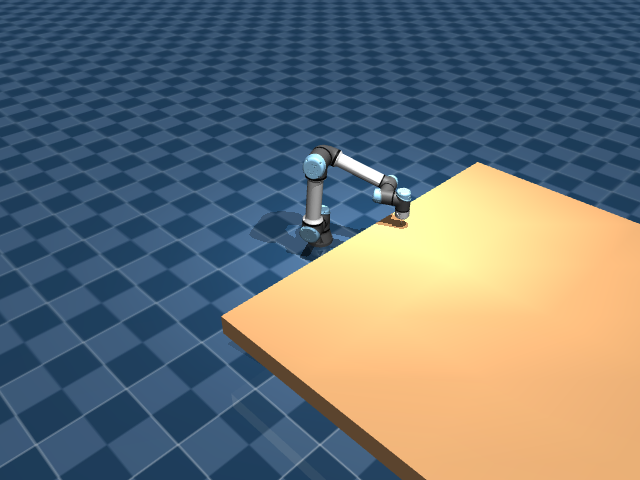

In [29]:
# Use the inverse kinematics to make a start pose for the robot
sol = ur5e.invkin(ctr[0])
print(sol.q)
# visualize the position
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)
renderer.update_scene(ur5e.d, camera="fixed", scene_option=dict())
# show image
media.show_image(renderer.render())
# joints pose
#[ 0.46362935 -1.63647675 -1.8596509  -1.2162613   1.57079635  2.03442568] # CBF

# Admittance Controller
More like an impedance controller, doesnt follow a trajectory but complies with environment

In [24]:
import numpy as np
import mujoco
from tqdm import tqdm

M_diag = np.array([5.0, 5.0, 5.0, 5.0, 5.0, 5.0])  # Reduce mass in Z for faster descent
D_diag = np.array([50, 50, 50, 10, 10, 10])  # Reduce damping for less resistance
K_diag = np.array([0, 0, 0, 0, 0, 0])  # Stiffness matrix 0 = full admittance

M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

compliance_vector = np.array([1, 1, 1, 1, 1, 1])

x_e = np.zeros(6)  # Pos error
v_e = np.zeros(6)  # Vel error
v_e_last = np.zeros(6)  # Previous velocity

showVideo = True
duration = 5
framerate = 30  
stepsize = ur5e.m.opt.timestep
n_steps = int(np.ceil(duration / stepsize))

frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 3))
torques = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []
time_log = []
force_log = []  
vel_log = np.zeros((n_steps, 6))


#sol = np.array([0.27174445, -1.40474226, -2.07800756, -1.2296391, 1.57079635, 1.84254078])
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
#sol.qvel[:] = 0.0
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # cartesian
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    vel_log[idx, :] = ur5e.d.qvel.copy()
    # At end effector
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    #f_ext[2] = -0.05  # gravity
    
    f_ext *= compliance_vector
    
    # Admittance - acc in Cartesian Space
    acc_e = np.linalg.inv(M) @ (f_ext - K @ x_e - D @ v_e)
    # integrate vel and pos err
    v_e = (stepsize * 0.5) * (acc_e + v_e_last) + v_e_last
    x_e = (stepsize * 0.5) * (v_e + v_e_last) + x_e
    v_e_last = v_e.copy()
    
    acc_joint = np.linalg.pinv(J) @ (acc_e - dJ @ ur5e.d.qvel) # joint space
    
    # get torque using inverse dynamics
    prev_qacc = ur5e.d.qacc.copy()
    ur5e.d.qacc[:] = acc_joint
    mujoco.mj_inverse(ur5e.m, ur5e.d)
    torque_cmd = ur5e.d.qfrc_inverse.copy()
    ur5e.d.qacc[:] = prev_qacc
    
    # Apply torque control
    ur5e.d.ctrl[:] = torque_cmd
    
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate([tcp_pos.t, tcp_pos.rpy(order='xyz')])
    velocities[idx] = v_e
    forces[idx] = f_ext[:3]
    torques[idx] = torque_cmd
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

if showVideo:
    media.show_video(frames, fps=framerate)


100%|█████████▉| 4.999999999999671/5 [00:09<00:00,  1.82s/it]  


# Plots

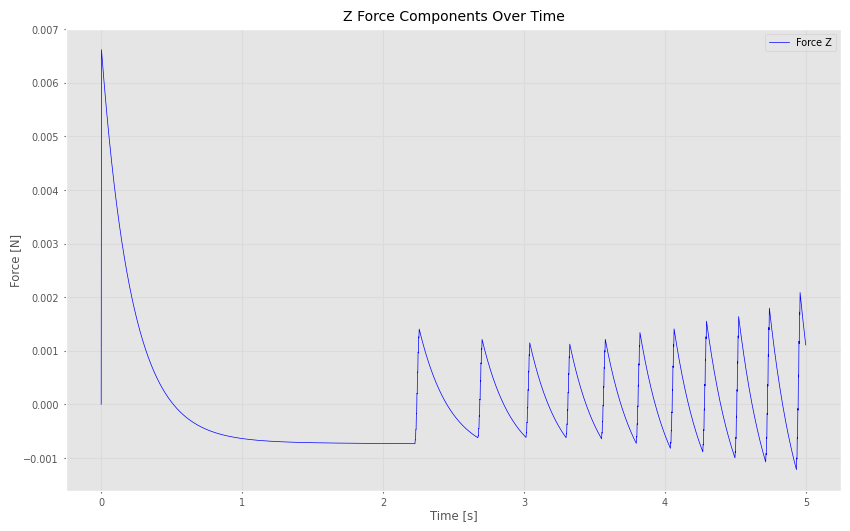

"\nplt.figure(figsize=(10, 6))\nplt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')\nplt.xlabel('Time [s]')\nplt.ylabel('Force Magnitude [N]')\nplt.title('Contact Force Magnitude Over Time')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [25]:
# Convert logs to NumPy arrays
time_log = np.array(time_log)          # shape: (n_steps,)
force_log = np.array(force_log)        # shape: (n_steps, 3)

# Optionally, compute the overall magnitude of the force vector at each step
force_magnitude = np.linalg.norm(force_log, axis=1)
plt.figure(figsize=(10, 6))
#plt.plot(time_log, force_log[:, 0], label='Force X', color='r')
#plt.plot(time_log, force_log[:, 1], label='Force Y', color='g')
plt.plot(time_log, vel_log[:, 1], label='Force Z', color='b')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Z Force Components Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''
plt.figure(figsize=(10, 6))
plt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')
plt.xlabel('Time [s]')
plt.ylabel('Force Magnitude [N]')
plt.title('Contact Force Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''

# Torque plots

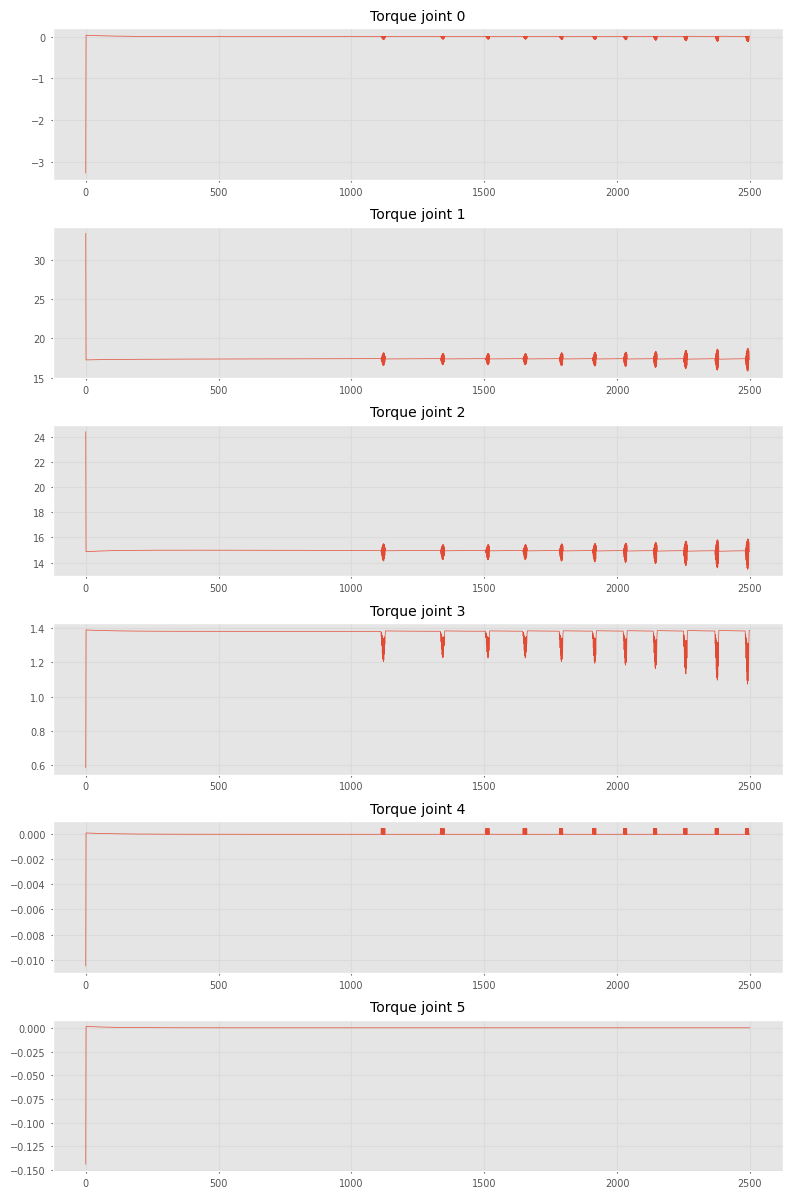

In [ ]:

fig, axs = plt.subplots(6, 1, figsize=(8, 12))

axs[0].plot(torques[:,0])
axs[0].set_title('Torque joint 0')

axs[1].plot(torques[:,1])
axs[1].set_title('Torque joint 1')

axs[2].plot(torques[:,2])
axs[2].set_title('Torque joint 2')

axs[3].plot(torques[:,3])
axs[3].set_title('Torque joint 3')

axs[4].plot(torques[:,4])
axs[4].set_title('Torque joint 4')

axs[5].plot(torques[:,5])
axs[5].set_title('Torque joint 5')

plt.tight_layout()
plt.show()



# Traditional ECBF with q_min,max + v_min,max, L_f h(x), L_g h(x) and lambda
Pole placement

In [58]:
import numpy as np
import mujoco
from cvxopt import matrix, solvers
from tqdm import tqdm
import matplotlib.pyplot as plt

solvers.options['show_progress'] = False

# Cartesian
M_diag = np.array([5.0]*6)
D_diag = np.array([5, 5, 5, 10, 10, 10])
K_diag = np.array([10, 10, 10, 5, 5, 5])
M_cart = np.diag(M_diag)
D_cart = np.diag(D_diag)
K_cart = np.diag(K_diag)

# CBF
q_min = np.full(6, -2*np.pi/2)      # rad
q_max = np.full(6,  2*np.pi/2)    

vel_min = -0.1                   
vel_max =  0.1                   
lambda_cbf = 10                   # cbf 

# -------------------------------------------------------------------
# Safe Set and Barrier Function Definitions:
#
# The safe set for the joints is defined as:
#    C = { q ∈ ℝ⁶ : q_min ≤ q ≤ q_max }
#
# Its boundary is:
#    ∂C = { q : for some i, q_i = q_min or q_i = q_max }
#
# The interior is:
#    Int(C) = { q ∈ ℝ⁶ : q_min < q < q_max }
#
# For each joint i, we define two barrier functions:
#
#  Lower barrier:   h_lower(q_i) = q_i - q_min[i]    ≥ 0
#  Upper barrier:   h_upper(q_i) = q_max[i] - q_i    ≥ 0
#
# Their Lie derivatives (assuming double-integrator dynamics) are:
#  For x_i = [q_i, 𝑞̇_i]ᵀ,
#      f(x_i) = [𝑞̇_i, 0]ᵀ   and   g(x_i) = [0, 1]ᵀ.
#
# Thus, for h_lower:
#      L_f h_lower = 𝑞̇_i,   L_g h_lower = 0.
# An augmented (exponential) barrier is defined as:
#      ψ_lower(x_i) = 𝑞̇_i + λ (q_i - q_min[i])
# with
#      L_f ψ_lower = λ𝑞̇_i,   L_g ψ_lower = 1.
#
# Similarly for h_upper:
#      L_f h_upper = -𝑞̇_i,   L_g h_upper = 0,
# and the augmented barrier is:
#      ψ_upper(x_i) = -𝑞̇_i + λ (q_max[i] - q_i)
# with
#      L_f ψ_upper = -λ𝑞̇_i,   L_g ψ_upper = -1.
#
# In discrete time, approximating 𝑞̇_i(new) ≈ 𝑞̇_i + Δt·τ_i, the constraints become:
#      τ_i ≥ - (𝑞̇_i + λ (q_i - q_min[i])) / Δt   (from the lower barrier)
#      τ_i ≤ ( -𝑞̇_i + λ (q_max[i] - q_i)) / Δt    (from the upper barrier)
#
# Additionally, enforcing velocity limits:
#      τ_i ≥ (vel_min - 𝑞̇_i) / Δt   and   τ_i ≤ (vel_max - 𝑞̇_i) / Δt.
#
# These constraints are combined in a 1D QP for each joint.
#
# Finally, note that for the full state x = [q, 𝑞̇]ᵀ the dynamics are:
#      f(x) = [𝑞̇, 0]ᵀ,     g(x) = [0, I]ᵀ,
# which are used for the safety analysis. This formulation is that of an 
# Exponential Control Barrier Function (ECBF).
#
# -------------------------------------------------------------------


# Safe Set and ECBF Definitions:
#
# For each joint, define:
#   Lower barrier: h_lower = q - q_min  
#   Upper barrier: h_upper = q_max - q  
#
# In discrete time, with timestep Δt, the safety constraints are:
#   τ >= - (q_dot + λ*(q - q_min))/Δt    [from lower barrier]
#   τ <= ( -q_dot + λ*(q_max - q))/Δt     [from upper barrier]
#
# Also, enforce velocity limits:
#   τ >= (vel_min - q_dot)/Δt and τ <= (vel_max - q_dot)/Δt.
#
# solved per joint via a 1D QP.


compliance_vector = np.array([1, 1, 1, 1, 1, 1])

showVideo = True
duration = 5        
framerate = 30          
stepsize = ur5e.m.opt.timestep 
n_steps = int(np.ceil(duration / stepsize))


frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 3))
tau_nom_log = np.zeros((n_steps, 6))
tau_cbf_log = np.zeros((n_steps, 6))
h_log = np.zeros((n_steps, 6))       # barrier values (q - q_min)
time_log = []                       
q_log = np.zeros((n_steps, 6))        
q_dot_log = np.zeros((n_steps, 6))     

# Also log nominal states (without CBF filtering)
q_nom_log = np.zeros((n_steps, 6))    
q_dot_nom_log = np.zeros((n_steps, 6))
#actual_q_log = np.zeros((n_steps, 6))   


q_nom = ur5e.d.qpos.copy()
q_dot_nom = ur5e.d.qvel.copy()

x_e = np.zeros(6)   # Cartesian position error
v_e = np.zeros(6)   # Cartesian velocity error
v_e_last = np.zeros(6)

mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    q_log[idx, :] = ur5e.d.qpos.copy()
    q_dot_log[idx, :] = ur5e.d.qvel.copy()
    
  
    # Cartesian admittance dynamics
    # Compute desired Cartesian acceleration: M*ẍ + D*ẋ + K*x = f_ext
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    f_ext[2] -= 0.5  # Add gravity force
    f_ext *= compliance_vector
    acc_e = np.linalg.inv(M_cart) @ (f_ext - K_cart @ x_e - D_cart @ v_e)
    v_e = v_e + stepsize * 0.5 * (acc_e + v_e_last)
    x_e = x_e + stepsize * 0.5 * (v_e + v_e_last)
    v_e_last = v_e.copy()
    
    # Map Cartesian Acceleration to Joint Acceleration
    acc_joint = np.linalg.pinv(J) @ (acc_e - dJ @ ur5e.d.qvel)
    
    # Nom
    q_dot_nom = q_dot_nom + stepsize * acc_joint
    q_nom = q_nom + stepsize * q_dot_nom
    q_nom_log[idx, :] = q_nom.copy()
    q_dot_nom_log[idx, :] = q_dot_nom.copy()
    
    # Nominal joint torques via inverse dynamics
    prev_qacc = ur5e.d.qacc.copy()
    ur5e.d.qacc[:] = acc_joint
    mujoco.mj_inverse(ur5e.m, ur5e.d)
    tau_nom = ur5e.d.qfrc_inverse.copy()
    ur5e.d.qacc[:] = prev_qacc
    tau_nom_log[idx, :] = tau_nom.copy()
    

    # For each joint, enforce:
    #    τ >= - (q_dot + λ*(q - q_min))/stepsize    and
    #    τ <= ( -q_dot + λ*(q_max - q))/stepsize
    # plus velocity constraints.
    tau_cbf = np.zeros(6)
    q = ur5e.d.qpos[:]     
    q_dot = ur5e.d.qvel[:]   
    for i in range(6):
        lower_barrier_constraint = - (q_dot[i] + lambda_cbf * (q[i] - q_min[i])) / stepsize
        upper_barrier_constraint = ( -q_dot[i] + lambda_cbf * (q_max[i] - q[i]) ) / stepsize
        vel_lower_constraint = (vel_min - q_dot[i]) / stepsize
        vel_upper_constraint = (vel_max - q_dot[i]) / stepsize
        tau_lower_bound = max(lower_barrier_constraint, vel_lower_constraint)
        tau_upper_bound = min(upper_barrier_constraint, vel_upper_constraint)
        # Solve a 1D QP for joint i:
        P = matrix(np.array([[1.0]]))
        q_vec = matrix(np.array([-tau_nom[i]]))
        G = matrix(np.array([[-1.0], [1.0]]))
        h_qp = matrix(np.array([-tau_lower_bound, tau_upper_bound]))
        sol_qp = solvers.qp(P, q_vec, G, h_qp)
        if sol_qp['status'] == 'optimal':
            tau_cbf[i] = sol_qp['x'][0]
        else:
            tau_cbf[i] = tau_nom[i]
    tau_cbf_log[idx, :] = tau_cbf.copy()
    
    h_log[idx, :] = q - q_min
    
    ur5e.d.ctrl[:] = tau_cbf
    mujoco.mj_step(ur5e.m, ur5e.d)

    quat_e = r2q(tcp_pos.R)  # convert rotation to quaternion
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate((tcp_pos.t, tcp_pos.rpy(order='xyz')))
    velocities[idx] = v_e
    forces[idx] = f_ext[:3]
    time_log.append(ur5e.d.time)
    

    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    idx += 1

progress_bar.close()
if showVideo:
    media.show_video(frames, fps=framerate)


100%|█████████▉| 4.999999999999671/5 [00:15<00:00,  3.13s/it]   


# Plots

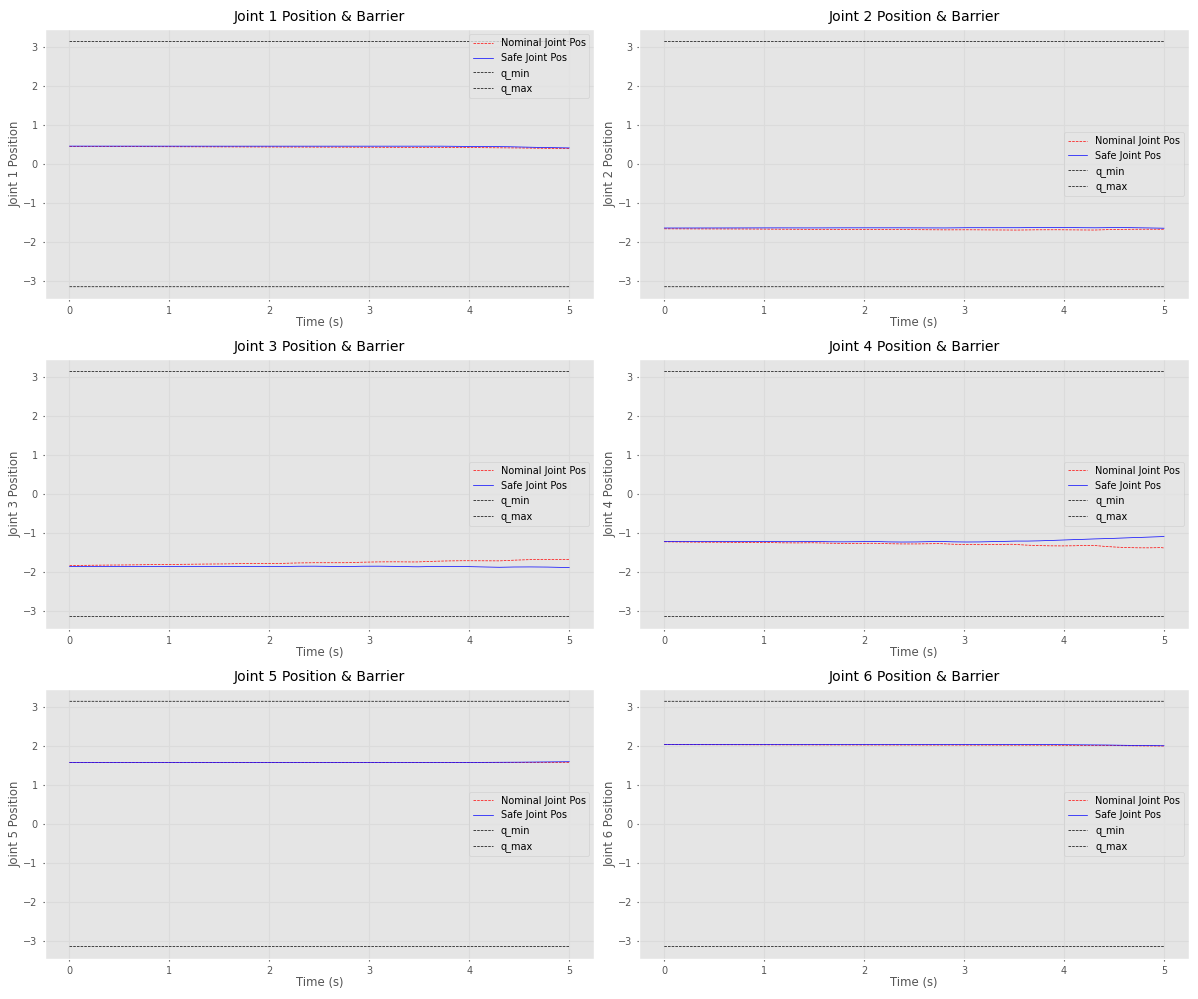

In [59]:
import matplotlib.pyplot as plt
import numpy as np

time = np.array(time_log)
n_joints = 6

plt.figure(figsize=(12, 10))
for i in range(n_joints):
    plt.subplot(3, 2, i+1)
    
    # Plot the nominal and safe joint positions
    plt.plot(time, q_nom_log[:, i], 'r--', label='Nominal Joint Pos')
    plt.plot(time, q_log[:, i], 'b-', label='Safe Joint Pos')
    
    # Plot the barrier function h = q - q_min
    #plt.plot(time, h_log[:, i], 'g-', label='Barrier h (q - q_min)')
    
    # Plot horizontal lines for q_min and q_max
    # (Here we replicate them at every time step to make a line across the plot)
    plt.plot(time, np.full_like(time, q_min[i]), 'k--', label='q_min')
    plt.plot(time, np.full_like(time, q_max[i]), 'k--', label='q_max')
    
    plt.xlabel('Time (s)')
    plt.ylabel(f'Joint {i+1} Position')
    plt.legend()
    plt.title(f'Joint {i+1} Position & Barrier')
    
plt.tight_layout()
plt.show()


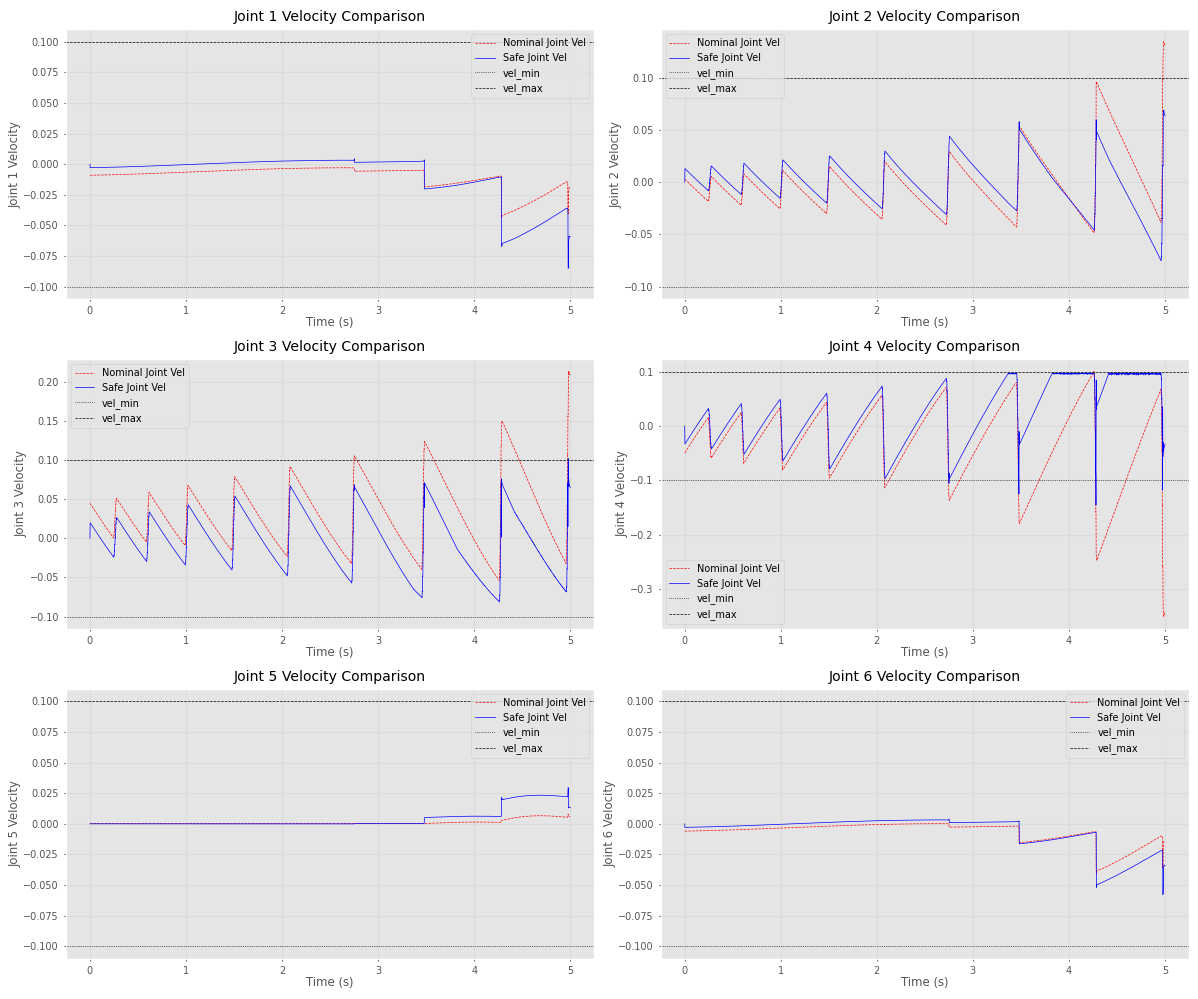

In [60]:
import matplotlib.pyplot as plt
import numpy as np

time = np.array(time_log)
n_joints = 6

plt.figure(figsize=(12, 10))
for i in range(n_joints):
    plt.subplot(3, 2, i+1)
    
    # Plot the nominal and safe joint velocities
    plt.plot(time, q_dot_nom_log[:, i], 'r--', label='Nominal Joint Vel')
    plt.plot(time, q_dot_log[:, i], 'b-', label='Safe Joint Vel')
    
    # Plot horizontal lines for vel_min and vel_max
    plt.axhline(vel_min, color='k', linestyle=':', label='vel_min')
    plt.axhline(vel_max, color='k', linestyle='--', label='vel_max')
    
    plt.xlabel('Time (s)')
    plt.ylabel(f'Joint {i+1} Velocity')
    plt.legend()
    plt.title(f'Joint {i+1} Velocity Comparison')

plt.tight_layout()
plt.show()


# Admittance following trajectory with tau_min,max

In [87]:
import numpy as np
import mujoco
from cvxopt import matrix, solvers
from tqdm import tqdm
import matplotlib.pyplot as plt

solvers.options['show_progress'] = False

M_diag = np.array([50.0, 50.0, 50.0, 12.0, 12.0, 12.0])  # Mass matrix for admittance control
D_diag = np.array([100, 100, 100, 25, 25, 25])            # Damping matrix
K_diag = np.array([100, 100, 100, 25, 25, 25])             # Stiffness for trajectory tracking

M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

MAX_TORQUE = np.array([0.3, -34.0, -34.0, -8.0, 0.1, 0.05]) 
MIN_TORQUE =  np.array([-1, -40.0, -38.0, -10.0, -0.3, -0.05])
#MAX_TORQUE = np.array([300.0, 340.0, 340.0, 800.0, 1800.0, 1800.0]) 
#MIN_TORQUE =  -MAX_TORQUE

time_log = []
force_log = []  
duration = 5        # seconds
framerate = 30      # Hz
stepsize = ur5e.m.opt.timestep  # Simulation time step (Δt)
n_steps = int(np.ceil(duration / stepsize))
showVideo = True

# Logging arrays
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 6))
torques = np.zeros((n_steps, 6))        # safe torques (after QP)
tau_nom_log = np.zeros((n_steps, 6))      # nominal torques (before QP)
# We log a simple “barrier” value as MAX_TORQUE - tau_safe (for example)
h_log = np.zeros((n_steps, 6))
# Also log the actual joint positions (6 joints)
q_log = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []
tau_cbf_log = np.zeros((n_steps, 6))

trajectory_amplitude = 0.04
trajectory_frequency = 0.1
z_velocity = -0.55  # Constant downward velocity
p = np.zeros((n_steps, 6))
dp = np.zeros((n_steps, 6))
ddp = np.zeros((n_steps, 6))

for i in range(n_steps):
    t = i * stepsize
    p[i, 0] = trajectory_amplitude * np.sin(2 * np.pi * trajectory_frequency * t)  # X motion
    dp[i, 0] = trajectory_amplitude * 2 * np.pi * trajectory_frequency * np.cos(2 * np.pi * trajectory_frequency * t)
    ddp[i, 0] = -trajectory_amplitude * (2 * np.pi * trajectory_frequency) ** 2 * np.sin(2 * np.pi * trajectory_frequency * t)
    
    p[i, 2] = z_velocity * t  # Downward motion in Z
    dp[i, 2] = z_velocity
    ddp[i, 2] = 0  # Constant velocity in Z → zero acceleration

mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0
gamma = 1.0
L_f_upper = np.zeros((6,))
L_g_upper = -np.eye(6)
L_f_lower = np.zeros((6,))
L_g_lower = np.eye(6)
tau_prev = np.zeros(6)
while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # Cartesian kin
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]

    f_ext *= 1.0
    
    # cart space
    target_pose = p[idx]
    error_in_base_frame = target_pose - np.concatenate([tcp_pos.t, np.zeros(3)])
    v_e = J @ ur5e.d.qvel
    
    # Admittance control
    acc_e = np.linalg.inv(M) @ (-D @ (v_e - dp[idx]) - K @ error_in_base_frame + ddp[idx])
    
    # nominal joint torques via inverse dynamics.
    tau = J.T @ (M @ acc_e + D @ (dp[idx] - v_e) + K @ error_in_base_frame)
    mass_matrix = np.zeros((ur5e.m.nv, ur5e.m.nv))
    mujoco.mj_fullM(ur5e.m, mass_matrix, ur5e.d.qM)
    coriolis_forces = ur5e.d.qfrc_bias.copy()
    tau += mass_matrix @ ur5e.d.qacc + coriolis_forces
    tau_nom = tau.copy()  # nominal torque command
    tau_nom_log[idx, :] = tau_nom.copy()
    
    # 6. Apply a QP to enforce both a maximum and a minimum torque limit.
    #    We solve:
    #       minimize   0.5 * ||τ - τ_nom||²
    #       subject to  MIN_TORQUE <= τ <= MAX_TORQUE.
    P = matrix(np.eye(6))
    q_vec = matrix(-tau_nom)
    # Stack constraints: τ <= MAX_TORQUE and -τ <= -MIN_TORQUE.
    G = matrix(np.vstack((np.eye(6), -np.eye(6))))
    h_vec = matrix(np.hstack((MAX_TORQUE, -MIN_TORQUE)))
    sol_qp = solvers.qp(P, q_vec, G, h_vec)
    tau_safe = np.array(sol_qp['x']).flatten()
    tau_cbf_log[idx, :] = tau_safe.copy()
    
    h_val = MAX_TORQUE - tau_safe
    h_log[idx, :] = h_val.copy()
    
    ur5e.d.ctrl[:] = tau_safe
    
    # Log
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate((tcp_pos.t, tcp_pos.rpy(order='xyz')))
    velocities[idx] = v_e
    forces[idx] = M @ acc_e
    q_log[idx, :] = ur5e.d.qpos.copy()
    
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])

    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

if showVideo:
    media.show_video(frames, fps=framerate)

100%|█████████▉| 4.999999999999671/5 [00:11<00:00,  2.26s/it]  


# Plots

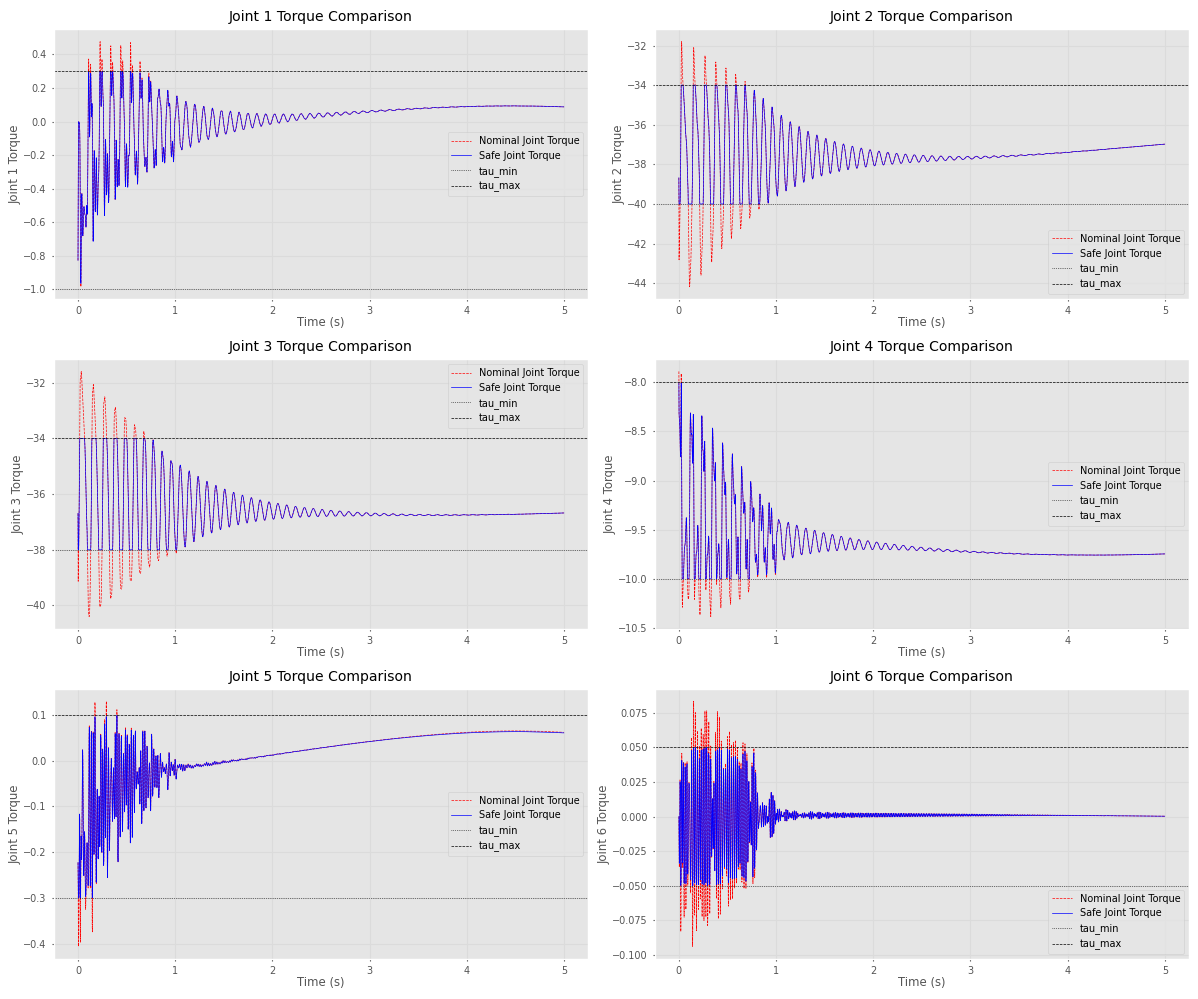

In [88]:
time = np.array(time_log)
n_joints = 6

plt.figure(figsize=(12, 10))
for i in range(n_joints):
    plt.subplot(3, 2, i+1)
    
    # Plot the nominal and safe joint velocities
    plt.plot(time, tau_nom_log[:, i], 'r--', label='Nominal Joint Torque')
    plt.plot(time, tau_cbf_log[:, i], 'b-', label='Safe Joint Torque')
    
    # Plot horizontal lines for vel_min and vel_max
    plt.axhline(MIN_TORQUE[i], color='k', linestyle=':', label='tau_min')
    plt.axhline(MAX_TORQUE[i], color='k', linestyle='--', label='tau_max')
    
    plt.xlabel('Time (s)')
    plt.ylabel(f'Joint {i+1} Torque')
    plt.legend()
    plt.title(f'Joint {i+1} Torque Comparison')

plt.tight_layout()
plt.show()

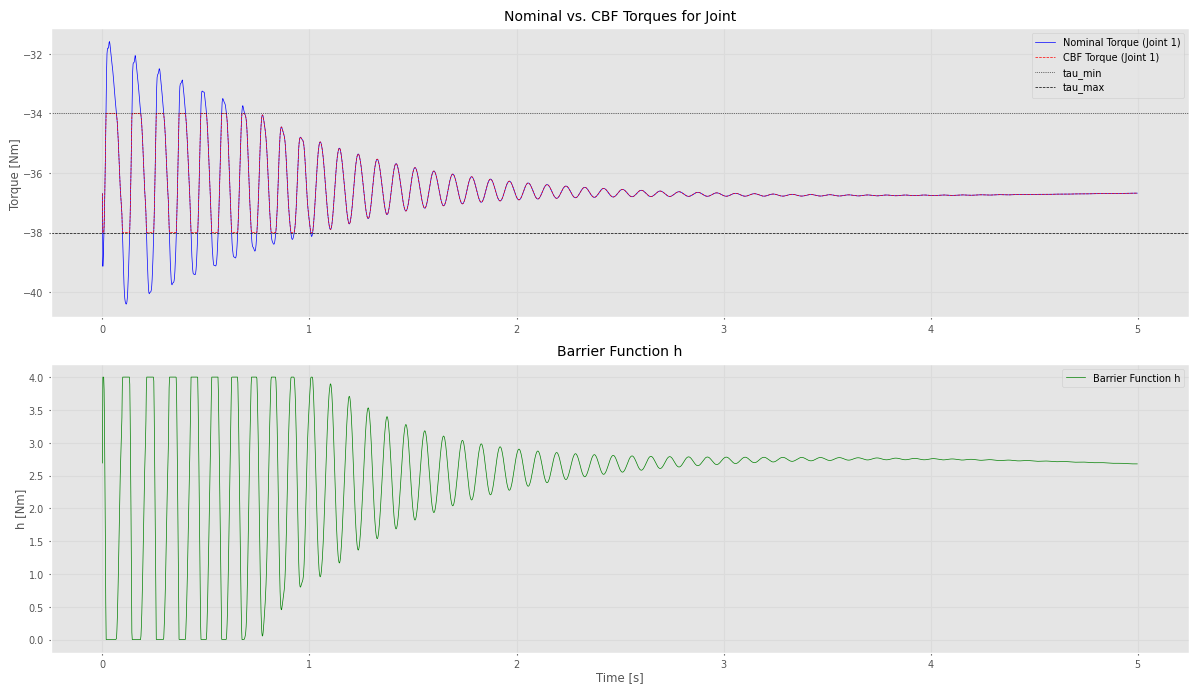

In [67]:
time_array = np.array(time_log)

plt.figure(figsize=(12, 10))
joint = 2
# Plot nominal and CBF torques for Joint 1 (index 0)
plt.subplot(3, 1, 1)
plt.plot(time_array, tau_nom_log[:, joint], 'b-', label='Nominal Torque (Joint 1)')
plt.plot(time_array, tau_cbf_log[:, joint], 'r--', label='CBF Torque (Joint 1)')
plt.axhline(MAX_TORQUE[joint], color='k', linestyle=':', label='tau_min')
plt.axhline(MIN_TORQUE[joint], color='k', linestyle='--', label='tau_max')
plt.ylabel('Torque [Nm]')
plt.title('Nominal vs. CBF Torques for Joint')
plt.legend()
plt.grid(True)
#[-1, 1 + -40, -30 + -40, -30
# Plot the barrier function h for Joint 1: h = MAX_TORQUE - tau_cbf.
plt.subplot(3, 1, 2)
plt.plot(time_array, h_log[:, joint], 'g-', label='Barrier Function h')
plt.xlabel('Time [s]')
plt.ylabel('h [Nm]')
plt.title('Barrier Function h')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# CBF torque_Min and torque_max
Ret god, men h er muligvis forkert og ingen alpha/gamma, L_f,g(x) 

In [47]:
import numpy as np
import mujoco
from cvxopt import matrix, solvers
from tqdm import tqdm
import matplotlib.pyplot as plt

solvers.options['show_progress'] = False

M_diag = np.array([5.0, 5.0, 5.0, 5.0, 5.0, 5.0])
D_diag = np.array([50, 50, 50, 10, 10, 10])
K_diag = np.array([100, 100, 100, 5, 5, 5])
M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

MAX_TORQUE = np.array([0.1, 30.0, 25.0, 28.0, 28.0, 28.0])
MIN_TORQUE = np.array([-1.0, 7.0, 3.0, -28.0, -28.0, -28.0])

compliance_vector = np.array([1, 1, 1, 1, 1, 1])

x_e = np.zeros(6)  # Cartesian position error
v_e = np.zeros(6)  # Cartesian velocity error
v_e_last = np.zeros(6)

showVideo = True
duration = 5  
framerate = 30  
stepsize = ur5e.m.opt.timestep
n_steps = int(np.ceil(duration / stepsize))

frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 3))

tau_nom_log = np.zeros((n_steps, 6))
tau_cbf_log = np.zeros((n_steps, 6))

h_log = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []
time_log = []
force_log = []  

mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)

    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    f_ext *= compliance_vector
    
    # 3. Admittance Dynamics - cartesian acc
    acc_e = np.linalg.inv(M) @ (f_ext - K @ x_e - D @ v_e)
    
    # trapezoidal, maybe try euler
    v_e = v_e + stepsize * 0.5 * (acc_e + v_e_last)
    x_e = x_e + stepsize * 0.5 * (v_e + v_e_last)
    v_e_last = v_e.copy()
    
    # Map cartesian to joint acc
    acc_joint = np.linalg.pinv(J) @ (acc_e - dJ @ ur5e.d.qvel)
    
    # nominal joint torques with inv dyn
    prev_qacc = ur5e.d.qacc.copy()
    ur5e.d.qacc[:] = acc_joint
    mujoco.mj_inverse(ur5e.m, ur5e.d)
    tau_nom = ur5e.d.qfrc_inverse.copy()  
    ur5e.d.qacc[:] = prev_qacc
    tau_nom_log[idx, :] = tau_nom.copy()
    
    # 6. Safety Filtering: Enforce both maximum and minimum torque constraints using a QP.
    #    We solve for tau ∈ ℝ⁶:
    #         minimize   0.5 * ||tau - tau_nom||²
    #         subject to MIN_TORQUE[i] <= tau_i <= MAX_TORQUE[i] for each joint i.
    # Formulated as:
    #    G*tau <= h, where we stack:
    #         tau_i <= MAX_TORQUE[i]        →   I*tau <= MAX_TORQUE
    #         -tau_i <= -MIN_TORQUE[i]      →  -I*tau <= -MIN_TORQUE
    P = matrix(np.eye(6))
    q_vec = matrix(-tau_nom)
    G = matrix(np.vstack((np.eye(6), -np.eye(6))))
    h_vec = matrix(np.hstack((MAX_TORQUE, -MIN_TORQUE)))
    sol_qp = solvers.qp(P, q_vec, G, h_vec)
    tau_cbf = np.array(sol_qp['x']).flatten()
    tau_cbf_log[idx, :] = tau_cbf.copy()
    
    h_log[idx, :] = MAX_TORQUE - tau_cbf
    
    ur5e.d.ctrl[:] = tau_cbf

    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate((tcp_pos.t, tcp_pos.rpy(order='xyz')))
    velocities[idx] = v_e
    forces[idx] = f_ext[:3]
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])

    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)

    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

if showVideo:
    media.show_video(frames, fps=framerate)



100%|█████████▉| 4.999999999999671/5 [00:10<00:00,  2.18s/it]  


# Plots

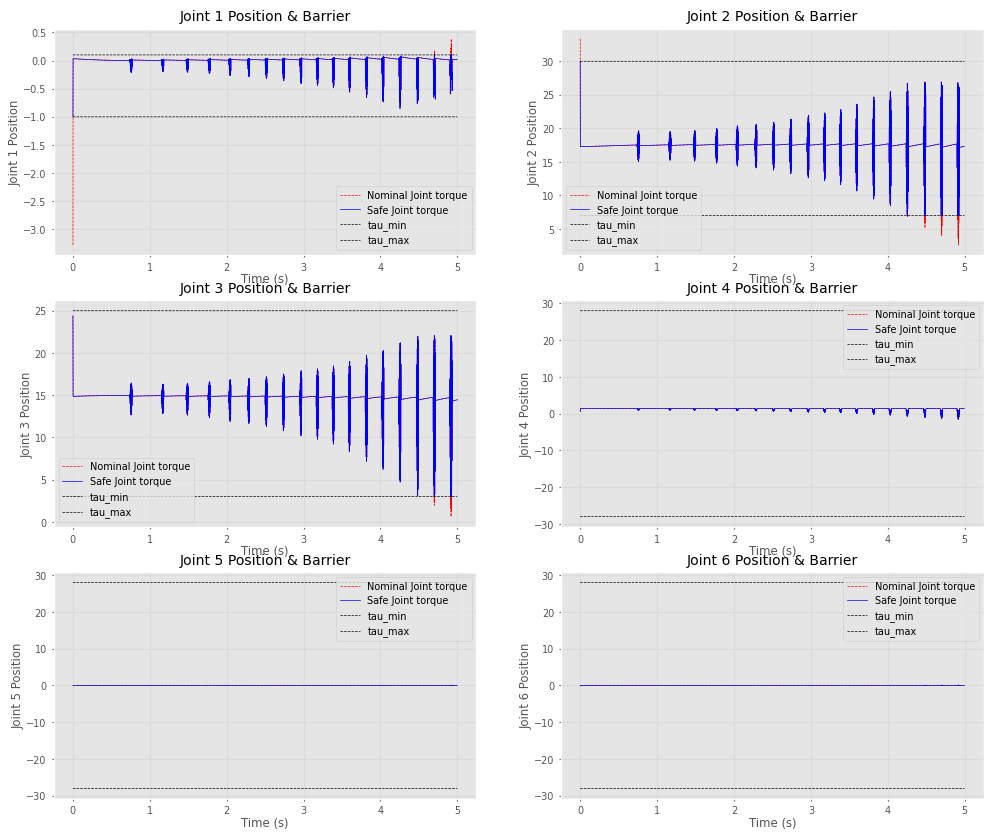

In [48]:
time = np.array(time_log)

plt.figure(figsize=(12, 10))
for i in range(n_joints):
    plt.subplot(3, 2, i+1)
    
    # Plot the nominal and safe joint positions
    plt.plot(time, tau_nom_log[:, i], 'r--', label='Nominal Joint torque')
    plt.plot(time, tau_cbf_log[:, i], 'b-', label='Safe Joint torque')
    
    # Plot the barrier function h = q - q_min
    #plt.plot(time, h_log[:, i], 'g-', label='Barrier h (q - q_min)')
    
    # Plot horizontal lines for q_min and q_max
    # (Here we replicate them at every time step to make a line across the plot)
    plt.plot(time, np.full_like(time, MIN_TORQUE[i]), 'k--', label='tau_min')
    plt.plot(time, np.full_like(time, MAX_TORQUE[i]), 'k--', label='tau_max')
    
    plt.xlabel('Time (s)')
    plt.ylabel(f'Joint {i+1} Position')
    plt.legend()
    plt.title(f'Joint {i+1} Position & Barrier')

# Admittance controller following trajectory
D=50,50,30,10,10,10

In [83]:
import numpy as np
import mujoco
from tqdm import tqdm

# Define Admittance Control Matrices
M_diag = np.array([50.0, 50.0, 50.0, 12.0, 12.0, 12.0])  # Mass matrix for admittance control
D_diag = np.array([100, 100, 100, 25, 25, 25])  # Damping matrix
K_diag = np.array([100, 100, 100, 25, 25, 25])  # Stiffness for trajectory tracking

M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

#MAX_TORQUE = np.array([150.0, 150.0, 150.0, 28.0, 28.0, 28.0])
time_log = []
force_log = []  # to store the first 3 components of the external force
duration = 5  # seconds
framerate = 30  # Hz
stepsize = ur5e.m.opt.timestep
n_steps = int(np.ceil(duration / stepsize))
showVideo = True

# Logging and video capture
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 6))
torques = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []
tau_log = np.zeros((n_steps, 6))

# Generate a sinusoidal trajectory with downward motion
trajectory_amplitude = 0.04
trajectory_frequency = 0.1
z_velocity = -0.55  # Constant downward velocity
p = np.zeros((n_steps, 6))
dp = np.zeros((n_steps, 6))
ddp = np.zeros((n_steps, 6))

for i in range(n_steps):
    t = i * stepsize
    p[i, 0] = trajectory_amplitude * np.sin(2 * np.pi * trajectory_frequency * t)  # X motion
    dp[i, 0] = trajectory_amplitude * 2 * np.pi * trajectory_frequency * np.cos(2 * np.pi * trajectory_frequency * t)
    ddp[i, 0] = -trajectory_amplitude * (2 * np.pi * trajectory_frequency) ** 2 * np.sin(2 * np.pi * trajectory_frequency * t)
    
    p[i, 2] = z_velocity * t  # Downward motion in Z
    dp[i, 2] = z_velocity
    ddp[i, 2] = 0  # Constant velocity in Z means zero acceleration

# Reset MuJoCo Simulation
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # Get Cartesian position and Jacobian
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)

    # Get force at the end effector
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    
    # Apply compliance selection
    f_ext *= compliance_vector
    
    # Compute trajectory error
    target_pose = p[idx]
    error_in_base_frame = target_pose - np.concatenate([tcp_pos.t, np.zeros(3)])
    v_e = J @ ur5e.d.qvel
    
    # Admittance control: Compute desired acceleration
    acc_e = np.linalg.inv(M) @ (-D @ (v_e - dp[idx]) - K @ error_in_base_frame + ddp[idx])
    
    # Compute joint torques
    tau = J.T @ (M @ acc_e + D @ (dp[idx] - v_e) + K @ error_in_base_frame)
    mass_matrix = np.zeros((ur5e.m.nv, ur5e.m.nv))
    mujoco.mj_fullM(ur5e.m, mass_matrix, ur5e.d.qM)
    coriolis_forces = ur5e.d.qfrc_bias.copy()
    tau += mass_matrix @ ur5e.d.qacc + coriolis_forces
    tau_log[idx, :] = tau.copy()
    # Clamp torques
    #tau = np.clip(tau, -MAX_TORQUE, MAX_TORQUE)
    
    # Apply torque control
    ur5e.d.ctrl[:] = tau
    
    # Log data
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate([tcp_pos.t, tcp_pos.rpy(order='xyz')])
    velocities[idx] = v_e
    forces[idx] = M @ acc_e
    torques[idx] = tau
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    # Capture video frames
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        #print(pixels.shape, pixels.dtype)
        frames.append(pixels)
    
    # Step simulation
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

# Show video
if showVideo:
    media.show_video(frames, fps=framerate)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|█████████▉| 4.999999999999671/5 [00:08<00:00,  1.72s/it]  


# Plots

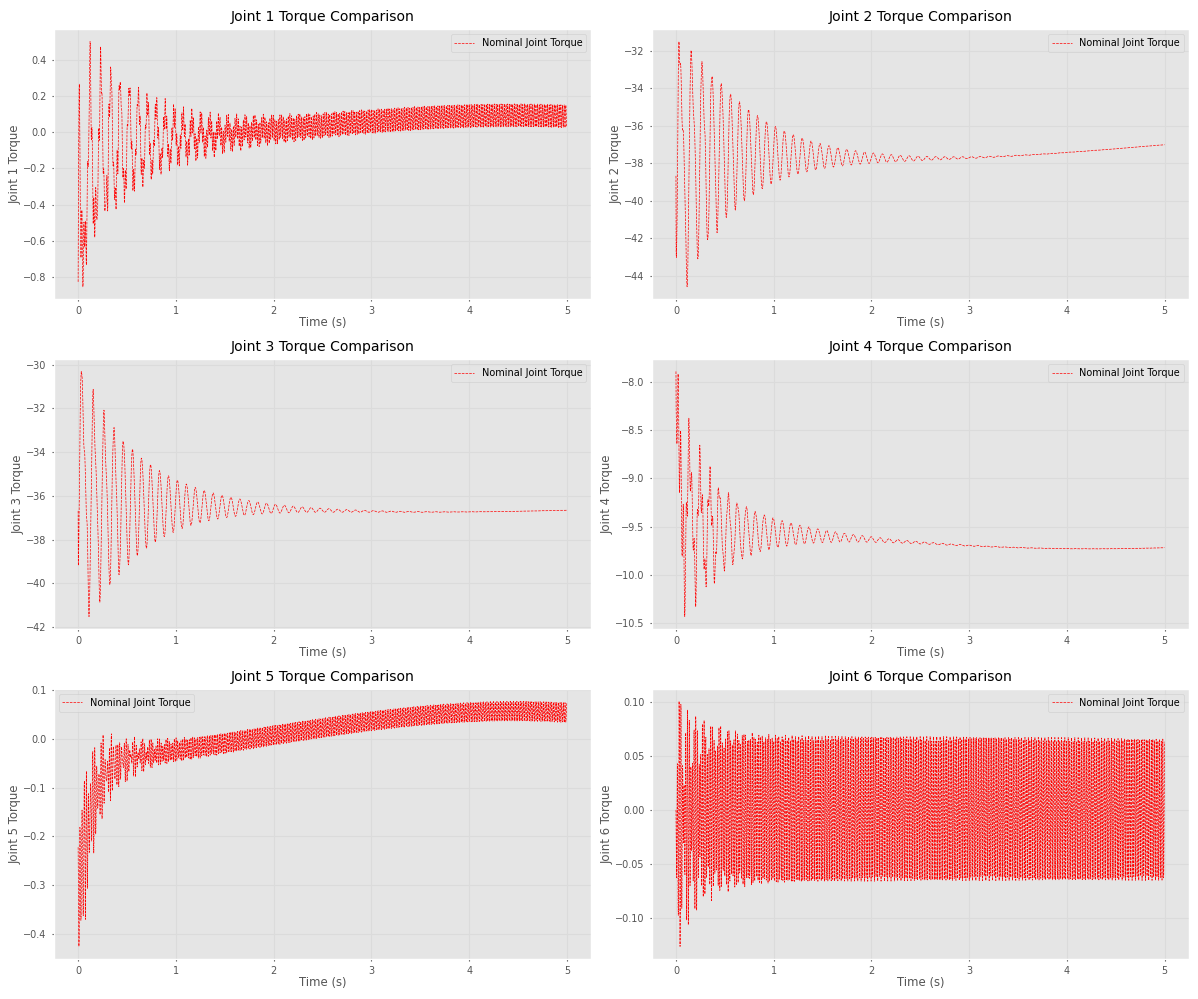

In [84]:
time = np.array(time_log)
n_joints = 6

plt.figure(figsize=(12, 10))
for i in range(n_joints):
    plt.subplot(3, 2, i+1)
    
    # Plot the nominal and safe joint velocities
    plt.plot(time, tau_log[:, i], 'r--', label='Nominal Joint Torque')
    
    plt.xlabel('Time (s)')
    plt.ylabel(f'Joint {i+1} Torque')
    plt.legend()
    plt.title(f'Joint {i+1} Torque Comparison')

plt.tight_layout()
plt.show()

# Admittance controller no trac tau_max

In [56]:
import numpy as np
import mujoco
from cvxopt import matrix, solvers
from tqdm import tqdm
import matplotlib.pyplot as plt

solvers.options['show_progress'] = False
M_diag = np.array([5.0, 5.0, 5.0, 5.0, 5.0, 5.0])
D_diag = np.array([50, 50, 50, 10, 10, 10])
K_diag = np.array([100, 100, 100, 5, 5, 5])
M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

MAX_TORQUE = np.array([150.0, 30.0, 25.0, 28.0, 28.0, 28.0])

compliance_vector = np.array([1, 1, 1, 1, 1, 1])

x_e = np.zeros(6)  # Cartesian position error
v_e = np.zeros(6)  # Cartesian velocity error
v_e_last = np.zeros(6)

showVideo = True
duration = 5  # seconds
framerate = 30  # Hz
stepsize = ur5e.m.opt.timestep  
n_steps = int(np.ceil(duration / stepsize))


frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 3))
tau_nom_log = np.zeros((n_steps, 6))
tau_safe_log = np.zeros((n_steps, 6))
# And we log the barrier function h = MAX_TORQUE - tau_safe:
h_log = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []
time_log = []
force_log = []  # log external force (first 3 components)

mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # 1. cartesian kinematics
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    
    # 2. external force at end-effector
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    f_ext *= compliance_vector
    
    # 3. admittance Dynamics - get desired cartesian acceleration.
    acc_e = np.linalg.inv(M) @ (f_ext - K @ x_e - D @ v_e)
    
    # trapezoidal integration, maybe switch to euler
    v_e = v_e + stepsize * 0.5 * (acc_e + v_e_last)
    x_e = x_e + stepsize * 0.5 * (v_e + v_e_last)
    v_e_last = v_e.copy()
    
    # 4. cartesian to joint acc
    acc_joint = np.linalg.pinv(J) @ (acc_e - dJ @ ur5e.d.qvel)
    
    # 5. get nominal joint torques via inverse dynamics.
    prev_qacc = ur5e.d.qacc.copy()
    ur5e.d.qacc[:] = acc_joint
    mujoco.mj_inverse(ur5e.m, ur5e.d)
    tau_nom = ur5e.d.qfrc_inverse.copy()  # nominal torque command
    ur5e.d.qacc[:] = prev_qacc
    
    # Log the nominal torques
    tau_nom_log[idx, :] = tau_nom.copy()
    
    # 6. Safety Filtering: Enforce maximum torque constraint using a QP.
    # We solve for tau ∈ ℝ⁶:
    #    minimize   0.5 * ||tau - tau_nom||²
    #    subject to tau_i <= MAX_TORQUE[i] for each joint i.
    # This QP is formulated over the full 6D torque vector.
    P = matrix(np.eye(6))
    q_vec = matrix(-tau_nom)
    # The constraints: tau_i <= MAX_TORQUE[i]  ⟺  I * tau <= MAX_TORQUE.
    G = matrix(np.eye(6))
    h_vec = matrix(MAX_TORQUE)
    sol_qp = solvers.qp(P, q_vec, G, h_vec)
    tau_safe = np.array(sol_qp['x']).flatten()
    tau_safe_log[idx, :] = tau_safe.copy()
    
    # barrier function
    # h = tau_max - tau_safe = 0 at boundary
    h_log[idx, :] = MAX_TORQUE - tau_safe
    
    ur5e.d.ctrl[:] = tau_safe
    
    # Log
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate((tcp_pos.t, tcp_pos.rpy(order='xyz')))
    velocities[idx] = v_e
    forces[idx] = f_ext[:3]
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

# Optionally display video
if showVideo:
    media.show_video(frames, fps=framerate)

# -------------------------------


100%|█████████▉| 4.999999999999671/5 [00:10<00:00,  2.13s/it]  


# Plots

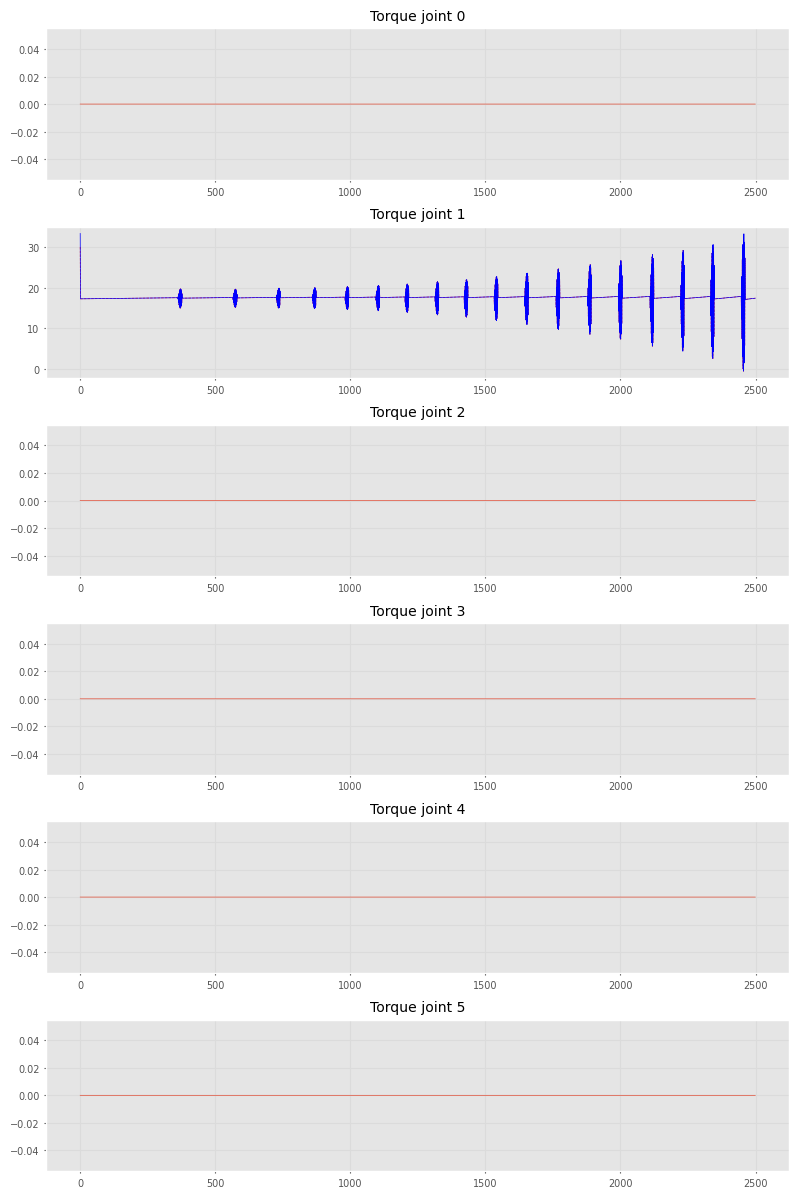

In [57]:

fig, axs = plt.subplots(6, 1, figsize=(8, 12))
# Plot the nominal and safe joint velocities
# plt.plot(time, q_dot_nom_log[:, i], 'r--', label='Nominal Joint Vel')
# plt.plot(time, q_dot_log[:, i], 'b-', label='Safe Joint Vel')
    
# Plot horizontal lines for vel_min and vel_max
# plt.axhline(vel_min, color='k', linestyle=':', label='vel_min')
# plt.axhline(vel_max, color='k', linestyle='--', label='vel_max')
axs[0].plot(torques[:,0])
axs[0].set_title('Torque joint 0')

axs[1].plot(tau_safe_log[:,1], 'r--', label='Nominal Joint Vel')
axs[1].plot(tau_nom_log[:,1], 'b-', label='Safe Joint Vel')
#plt.axhline(MAX_TORQUE, color='k', linestyle='--', label='vel_max')
axs[1].set_title('Torque joint 1')

axs[2].plot(torques[:,2])
axs[2].set_title('Torque joint 2')

axs[3].plot(torques[:,3])
axs[3].set_title('Torque joint 3')

axs[4].plot(torques[:,4])
axs[4].set_title('Torque joint 4')

axs[5].plot(torques[:,5])
axs[5].set_title('Torque joint 5')

plt.tight_layout()
plt.show()

